**Movie recommender by: Sepehr Mousaviyan**

# Import required libaries

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
# ! pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import ast
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
# ! pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

pd.options.display.max_columns=None

import warnings
warnings.simplefilter('ignore')

from datetime import datetime
# ! pip install tensorflow tensorflow_recommenders
import tensorflow as tf
import tensorflow_recommenders as tfrs

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from typing import Dict, Text

In [ ]:
# ! pwd
# ! ls drive/MyDrive/Movie_Recommender/archive

# drive.mount('/content/drive')

# def readCSV(name):
#   return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))
def readCSV(name):
  return pd.read_csv('{}'.format(name))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
md = readCSV('movies_metadata.csv')
links= readCSV('links_small.csv')
credits = readCSV('credits.csv')
keywords = readCSV('keywords.csv')
ratings = readCSV('ratings_small.csv')

<ipython-input-4-1755196bdf84>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))


Check missing values

In [ ]:
print('### md ###')
print( md.isnull().sum() / len(md) )
print('\n### links ###')
print( links.isnull().sum() / len(links) )
print('\n### credits ###')
print( credits.isnull().sum() / len(credits) )
print('\n### keywords ###')
print( keywords.isnull().sum() / len(keywords) )
print('\n### ratings ###')
print( ratings.isnull().sum() / len(ratings) )

### md ###
adult                    0.000000
belongs_to_collection    0.901157
budget                   0.000000
genres                   0.000000
homepage                 0.828839
id                       0.000000
imdb_id                  0.000374
original_language        0.000242
original_title           0.000000
overview                 0.020983
popularity               0.000110
poster_path              0.008490
production_companies     0.000066
production_countries     0.000066
release_date             0.001914
revenue                  0.000132
runtime                  0.005785
spoken_languages         0.000132
status                   0.001914
tagline                  0.551049
title                    0.000132
video                    0.000132
vote_average             0.000132
vote_count               0.000132
dtype: float64

### links ###
movieId    0.000000
imdbId     0.000000
tmdbId     0.001425
dtype: float64

### credits ###
cast    0.0
crew    0.0
id      0.0
dtype: float64


In [ ]:
md = md[["id","title","genres","original_language","overview","release_date","vote_average", "vote_count"]]
credits = credits[["id","cast"]]

In [ ]:
md["id"] = md["id"].astype(str)
md["title"] = md["title"].astype(str)
md["genres"] = md["genres"].astype(str)
md["original_language"] = md["original_language"].astype(str)
md["overview"] = md["overview"].astype(str)
md["release_date"] = md["release_date"].astype(str)
md.dtypes

id                    object
title                 object
genres                object
original_language     object
overview              object
release_date          object
vote_average         float64
vote_count           float64
dtype: object

In [ ]:
def unpack_genre(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
md['genres'] = md.genres.apply(lambda x : unpack_genre(x) )

In [ ]:
def transform_date(x):
    x = x.split("-")[0]
    if x == 'nan':
        return None
    else:
        return x
md["release_date"] = md.release_date.apply(lambda x : transform_date(x) )

In [ ]:
keywords["id"] = keywords["id"].astype(str)
keywords["keywords"] = keywords["keywords"].astype(str)
keywords.dtypes

id          object
keywords    object
dtype: object

In [ ]:
def unpack_keywords(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
keywords['keywords'] = keywords.keywords.apply(lambda x : unpack_keywords(x) )

In [ ]:
ratings["userId"] = ratings["userId"].astype(str)
ratings["movieId"] = ratings["movieId"].astype(str)
ratings.dtypes

userId        object
movieId       object
rating       float64
timestamp      int64
dtype: object

In [ ]:
credits["id"] = credits["id"].astype(str)
credits["cast"] = credits["cast"].astype(str)
credits.dtypes

id      object
cast    object
dtype: object

In [ ]:
# ! pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
def unpack_cast(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
credits["cast"] = credits.cast.parallel_apply(lambda x : unpack_cast(x) )

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
movies = pd.merge(md, keywords, on='id', how='inner')
movies = pd.merge(movies, credits, on='id', how='inner').rename(columns={"id":"movieId"})
movies = movies.dropna(subset=["release_date"])
movies["release_date"] = movies["release_date"].astype('int32')
movies.head(3)

,movieId,title,genres,original_language,overview,release_date,vote_average,vote_count,keywords,cast
0,862,Toy Story,"[Animation, Comedy, Family]",en,"Led by Woody, Andy's toys live happily in his ...",1995,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]",en,When siblings Judy and Peter discover an encha...,1995,6.9,2413.0,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,15602,Grumpier Old Men,"[Romance, Comedy]",en,A family wedding reignites the ancient feud be...,1995,6.5,92.0,"[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."


In [ ]:
movie_ratings = pd.merge( ratings, movies,  on='movieId', how='left')
movie_ratings.head(3)

,userId,movieId,rating,timestamp,title,genres,original_language,overview,release_date,vote_average,vote_count,keywords,cast
0,1,31,2.5,1260759144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1029,3.0,1260759179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1061,3.0,1260759182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Content based

This approach gives the user movies similar to movie the user have watched.

In [ ]:
links= links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
links.head(5)

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
md = md.drop([19730, 29503, 35587])

In [ ]:
md['id'] = md['id'].astype('int')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 24)

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

<ipython-input-14-8b022d10038a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['tagline'] = smd['tagline'].fillna('')
<ipython-input-14-8b022d10038a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['description'] = smd['overview'] + smd['tagline']
<ipython-input-14-8b022d10038a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
tfidf_matrix.shape

(9099, 268124)

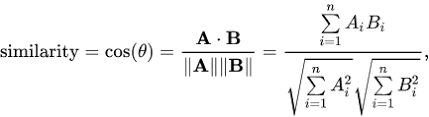

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('Outbreak').head(20)

7866                       Contagion
3693                   Osmosis Jones
3996                   Resident Evil
6962                   The Happening
6886                        Doomsday
7048                      Quarantine
31                    Twelve Monkeys
7401                       Pontypool
8871                          Maggie
7400                        Carriers
4664                   28 Days Later
149                          Hackers
1236                         Con Air
2989                        Badlands
3384                    The Forsaken
3592    American Ninja 3: Blood Hunt
12                             Balto
7311                          Thirst
7596        Resident Evil: Afterlife
4551         Cowboy Bebop: The Movie
Name: title, dtype: object

Based on meta data

In [ ]:
credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')
md.shape

(45463, 24)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 27)

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

<ipython-input-35-0380b14b24f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(literal_eval)
<ipython-input-35-0380b14b24f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['crew'] = smd['crew'].apply(literal_eval)
<ipython-input-35-0380b14b24f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

<ipython-input-37-48201c187769>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['director'] = smd['crew'].apply(get_director)
<ipython-input-37-48201c187769>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
<ipython-input-37-48201c187769>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

<ipython-input-38-101b592082c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
<ipython-input-38-101b592082c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
<ipython-input-38-101b592082c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

<ipython-input-39-b4f6ebaa1571>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)


In [ ]:
s = s.value_counts()
s[:10]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
violence                264
love                    222
musical                 219
sex                     219
suspense                212
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('sportingly')

'sport'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

<ipython-input-48-00d9efff34c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(filter_keywords)
<ipython-input-48-00d9efff34c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
<ipython-input-48-00d9efff34c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [ ]:
smd['soup'] = smd['keywords']
smd['soup'] = smd['soup'] + smd['cast']
smd['soup'] = smd['soup'] + smd['director']
# smd['soup'] = smd['soup'] + smd['genre']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

<ipython-input-59-a1b3590e4893>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['soup'] = smd['keywords']
<ipython-input-59-a1b3590e4893>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['soup'] = smd['soup'] + smd['cast']
<ipython-input-59-a1b3590e4893>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
get_recommendations('Memento').head(5)

2085        Following
4145         Insomnia
6623     The Prestige
7648        Inception
6218    Batman Begins
Name: title, dtype: object